In [3]:
%matplotlib inline


# Comparing edge-based and region-based segmentation


In this example, we will see how to segment objects from a background. We use
the ``coins`` image from ``skimage.data``, which shows several coins outlined
against a darker background.



Text(0.5, 1.0, 'histogram of gray values')

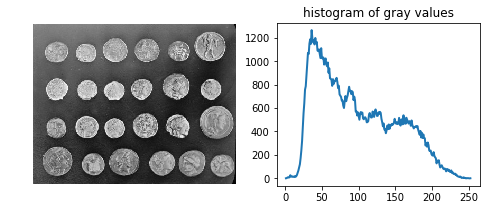

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.exposure import histogram

coins = data.coins()
hist, hist_centers = histogram(coins)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
axes[0].axis('off')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')

Thresholding
============

A simple way to segment the coins is to choose a threshold based on the
histogram of gray values. Unfortunately, thresholding this image gives a
binary image that either misses significant parts of the coins or merges
parts of the background with the coins:



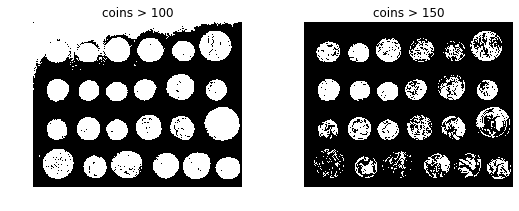

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

axes[0].imshow(coins > 100, cmap=plt.cm.gray, interpolation='nearest')
axes[0].set_title('coins > 100')

axes[1].imshow(coins > 150, cmap=plt.cm.gray, interpolation='nearest')
axes[1].set_title('coins > 150')

for a in axes:
    a.axis('off')

plt.tight_layout()

Edge-based segmentation
=======================

Next, we try to delineate the contours of the coins using edge-based
segmentation. To do this, we first get the edges of features using the
Canny edge-detector.



(-0.5, 383.5, 302.5, -0.5)

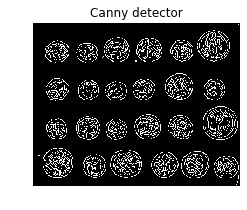

In [6]:
from skimage.feature import canny

edges = canny(coins)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(edges, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('Canny detector')
ax.axis('off')

These contours are then filled using mathematical morphology.



(-0.5, 383.5, 302.5, -0.5)

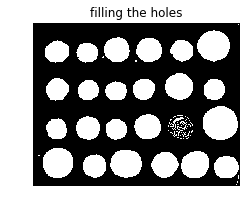

In [7]:
from scipy import ndimage as ndi

fill_coins = ndi.binary_fill_holes(edges)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(fill_coins, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('filling the holes')
ax.axis('off')

Small spurious objects are easily removed by setting a minimum size for
valid objects.



(-0.5, 383.5, 302.5, -0.5)

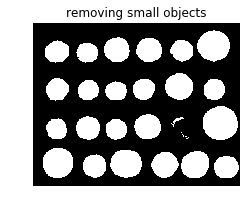

In [8]:
from skimage import morphology

coins_cleaned = morphology.remove_small_objects(fill_coins, 21)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(coins_cleaned, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('removing small objects')
ax.axis('off')

However, this method is not very robust, since contours that are not
perfectly closed are not filled correctly, as is the case for one unfilled
coin above.

Region-based segmentation
=========================

We therefore try a region-based method using the watershed transform.
First, we find an elevation map using the Sobel gradient of the image.



(-0.5, 383.5, 302.5, -0.5)

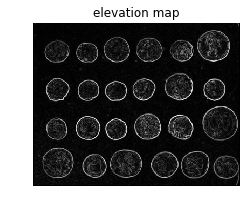

In [9]:
from skimage.filters import sobel

elevation_map = sobel(coins)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('elevation map')
ax.axis('off')

Next we find markers of the background and the coins based on the extreme
parts of the histogram of gray values.



(-0.5, 383.5, 302.5, -0.5)

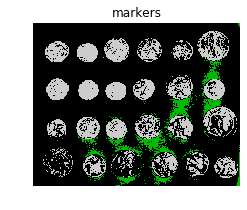

In [10]:
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 150] = 2

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(markers, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax.set_title('markers')
ax.axis('off')

Finally, we use the watershed transform to fill regions of the elevation
map starting from the markers determined above:



/anaconda3/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


(-0.5, 383.5, 302.5, -0.5)

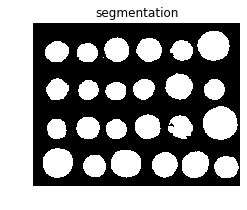

In [11]:
segmentation = morphology.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('segmentation')
ax.axis('off')

This last method works even better, and the coins can be segmented and
labeled individually.



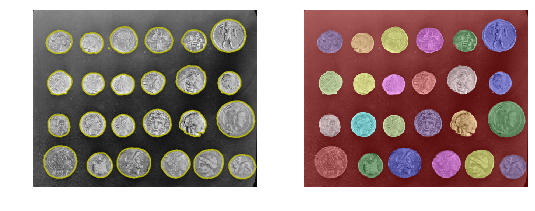

In [12]:
from skimage.color import label2rgb

segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_coins, image=coins)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay, interpolation='nearest')

for a in axes:
    a.axis('off')

plt.tight_layout()

plt.show()